# Exercises

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

> How many different cases are there, by department?

Text(0.5, 1.0, 'How many cases does each dept have?')

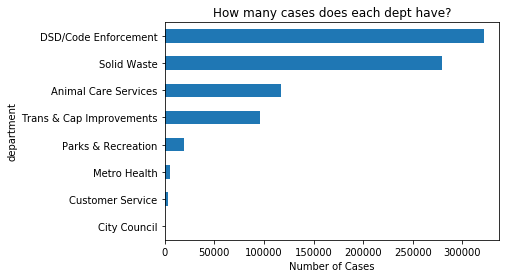

In [25]:
(
    df.groupBy('department')
    .count()
    .toPandas()
    .set_index('department')
    ['count']
    .sort_values()
    .plot.barh()
)
plt.xlabel('Number of Cases')
plt.title('How many cases does each dept have?')

> Does the percentage of cases that are late vary by department?

> On average, how late are the late cases by department?

Text(0.5, 0, 'Number of Cases on average')

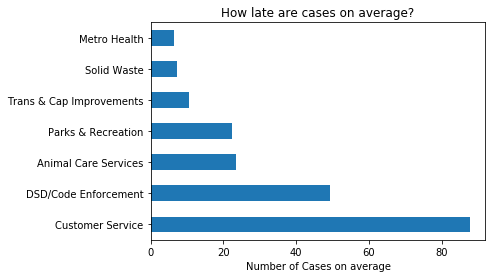

In [29]:
(
    df.where('case_late')
    .groupBy('department')
    .agg(avg('num_days_late')
         .alias('avg_days_late'))
    .toPandas()
    .set_index('department')['avg_days_late']
    .sort_values(ascending=False)
    .plot.barh()
)
plt.title("How late are cases on average?")
plt.ylabel("")
plt.xlabel("Number of Cases on average")

> What is the service type that is the most late? Just for Parks & Rec?

Text(0.5, 0, 'Number of days late')

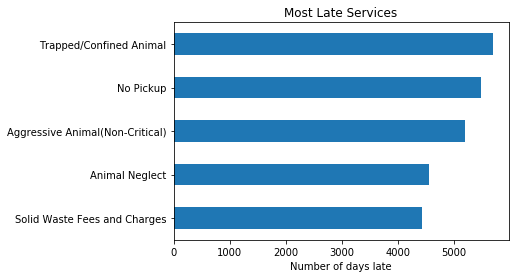

In [61]:
# most late of all service types
(
    df.where('case_late')
    .groupBy('service_request_type')
    .agg(count('num_days_late').alias('days_late'))
    .toPandas()
    .set_index('service_request_type')
    ['days_late']
    .sort_values()
    .tail(5)
    .plot.barh()
)
plt.title("Most Late Services")
plt.ylabel("")
plt.xlabel("Number of days late")

Text(0.5, 0, 'Number of days late')

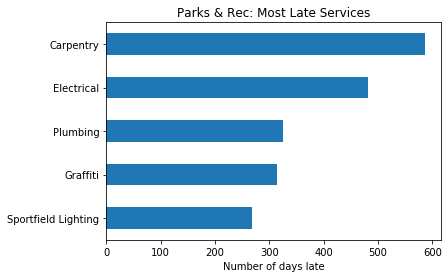

In [60]:
# parks & rec most late service type
(
    df.where('case_late')
    .where(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type')
    .agg(count('num_days_late').alias('days_late'))
    .toPandas()
    .set_index('service_request_type')
    ['days_late']
    .sort_values()
    .tail(5)
    .plot.barh()
)
plt.title("Parks & Rec: Most Late Services")
plt.ylabel("")
plt.xlabel("Number of days late")

> For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

Text(0.5, 0, 'Number of Cases')

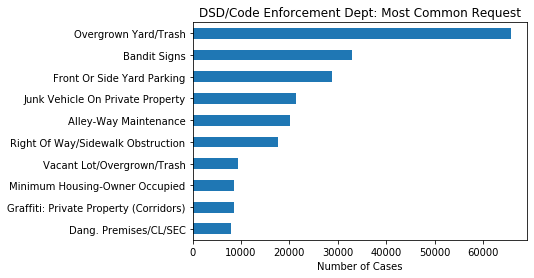

In [62]:
(
    df
    .where(col('department') == 'DSD/Code Enforcement')
    .groupBy('service_request_type')
    .count()
    .sort(('count'))
    .toPandas()
    .set_index('service_request_type')
    ['count']
    .tail(10)
    .plot.barh()
)
plt.title("DSD/Code Enforcement Dept: Most Common Request")
plt.ylabel("")
plt.xlabel("Number of Cases")

Text(0.5, 0, 'Number of Cases')

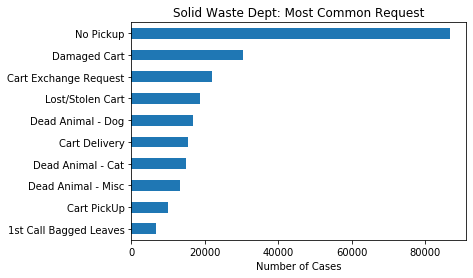

In [63]:
(
    df
    .where(col('department') == 'Solid Waste')
    .groupBy('service_request_type')
    .count()
    .sort(('count'))
    .toPandas()
    .set_index('service_request_type')
    ['count']
    .tail(10)
    .plot.barh()
)
plt.title("Solid Waste Dept: Most Common Request")
plt.ylabel("")
plt.xlabel("Number of Cases")

> Does whether or not its a weekend matter for when a case is opened/closed?

Text(0.5, 0, '')

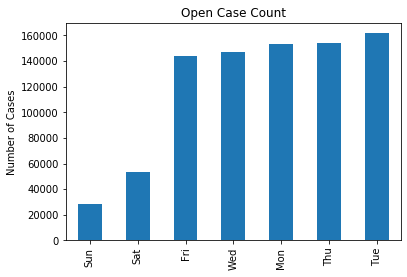

In [78]:
(
    df.withColumn("week_day", 
                  date_format(
                      col("case_opened_date"), "E"))
    .groupBy('week_day')
    .count()
    .sort('count')
    .toPandas()
    .set_index('week_day')
    ['count']
    .plot.bar()
)
plt.title("Open Case Count")
plt.ylabel("Number of Cases")
plt.xlabel("")

Text(0.5, 0, '')

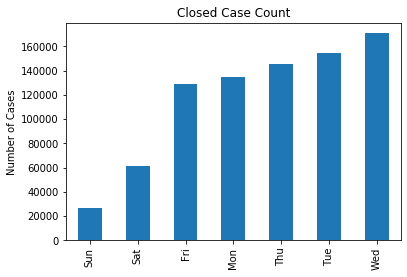

In [80]:
(
    df.withColumn("week_day", 
                  date_format(
                      col("case_closed_date"), "E"))
    .groupBy('week_day')
    .count()
    .na.drop()
    .sort('count')
    .toPandas()
    .set_index('week_day')
    ['count']
    .plot.bar()
)
plt.title("Closed Case Count")
plt.ylabel("Number of Cases")
plt.xlabel("")

> On average, how many cases are opened a day for the Customer Service department?

In [113]:
cases_opened_daily = (
    df.where(col("department") == "Customer Service")
    .select(date_format("case_opened_date", "yyyy-MM-dd")
            .alias("case_opened_date"))
    .groupBy('case_opened_date')
    .count()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_daily

case_opened_date
2017-01-02     3
2017-01-03     6
2017-01-04     2
2017-01-05     5
2017-01-06     3
              ..
2018-08-02    13
2018-08-03     8
2018-08-04     2
2018-08-06     5
2018-08-07     9
Name: count, Length: 512, dtype: int64

In [108]:
cases_opened_daily.mean()

5.564453125

> Does the number of service requests for the solid waste department vary by day of the week?